In [368]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
def cut_img(img_full):
    img_full = img_full[3:,3:]
    return img_full

def get_hsi(img_full):
    img_hsi = []
    for i in range(5):
        for j in range(5):
            img_hsi.append(img_full[i::5,j::5])
    return img_hsi

def cut_hsi(img_hsi):
    for i in range(len(img_hsi)):
        img_hsi[i] = img_hsi[i][0:216,0:408]
    return img_hsi

def get_chsi_from_hsi(img_hsi):
    img_chsi = np.zeros((216, 408, 25), dtype=float)
    for i in range(25):
        img_chsi[:,:,i] = img_hsi[i]
    return img_chsi

In [124]:
def preprocessing():
    img_full = img_full = plt.imread("hsi-2.png")
    img_full = cut_img(img_full)
    img_hsi = get_hsi(img_full)
    img_hsi = cut_hsi(img_hsi)
    img_chsi = get_chsi_from_hsi(img_hsi)
    return img_chsi, img_hsi

In [125]:
img_chsi, img_hsi = preprocessing()
img_chsi_part = img_chsi[0:125,175:300,:]

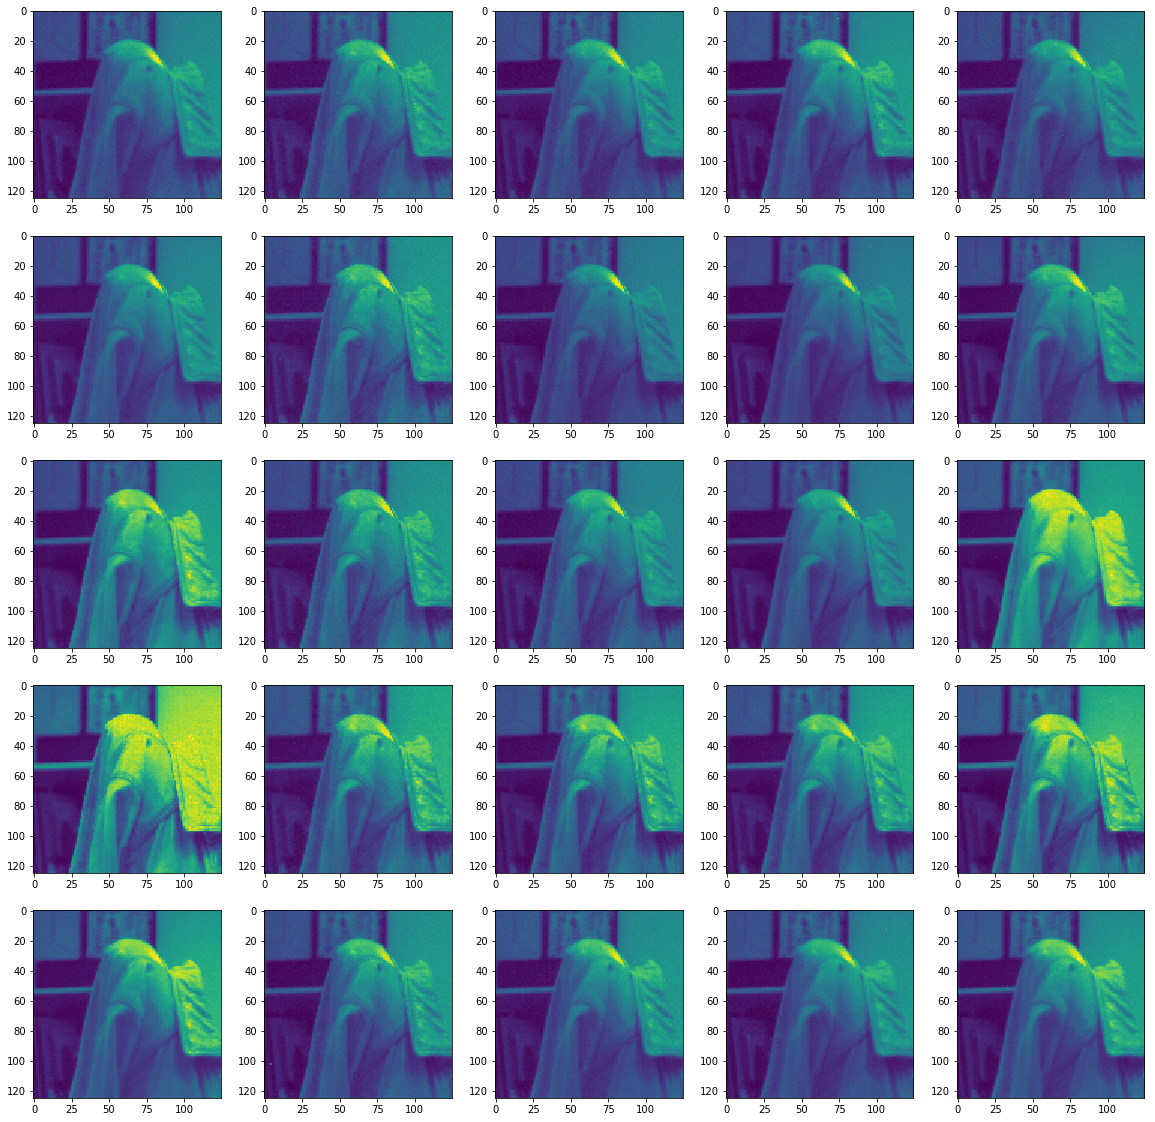

In [24]:
f, axarr = plt.subplots(5, 5, figsize = (20,20))
for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(img_chsi_part[:,:,5*i+j])

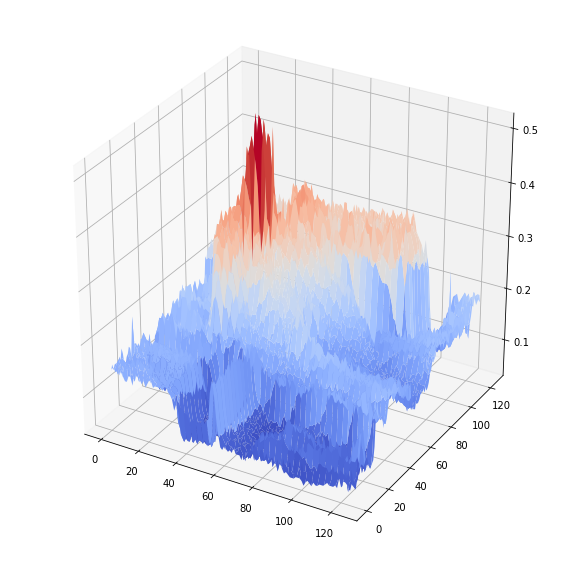

In [43]:
X = np.arange(0, img_chsi_part.shape[0])
Y = np.arange(0, img_chsi_part.shape[1])
Y, X = np.meshgrid(Y,X)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,img_chsi_part[:,:,0], cmap=cm.coolwarm)

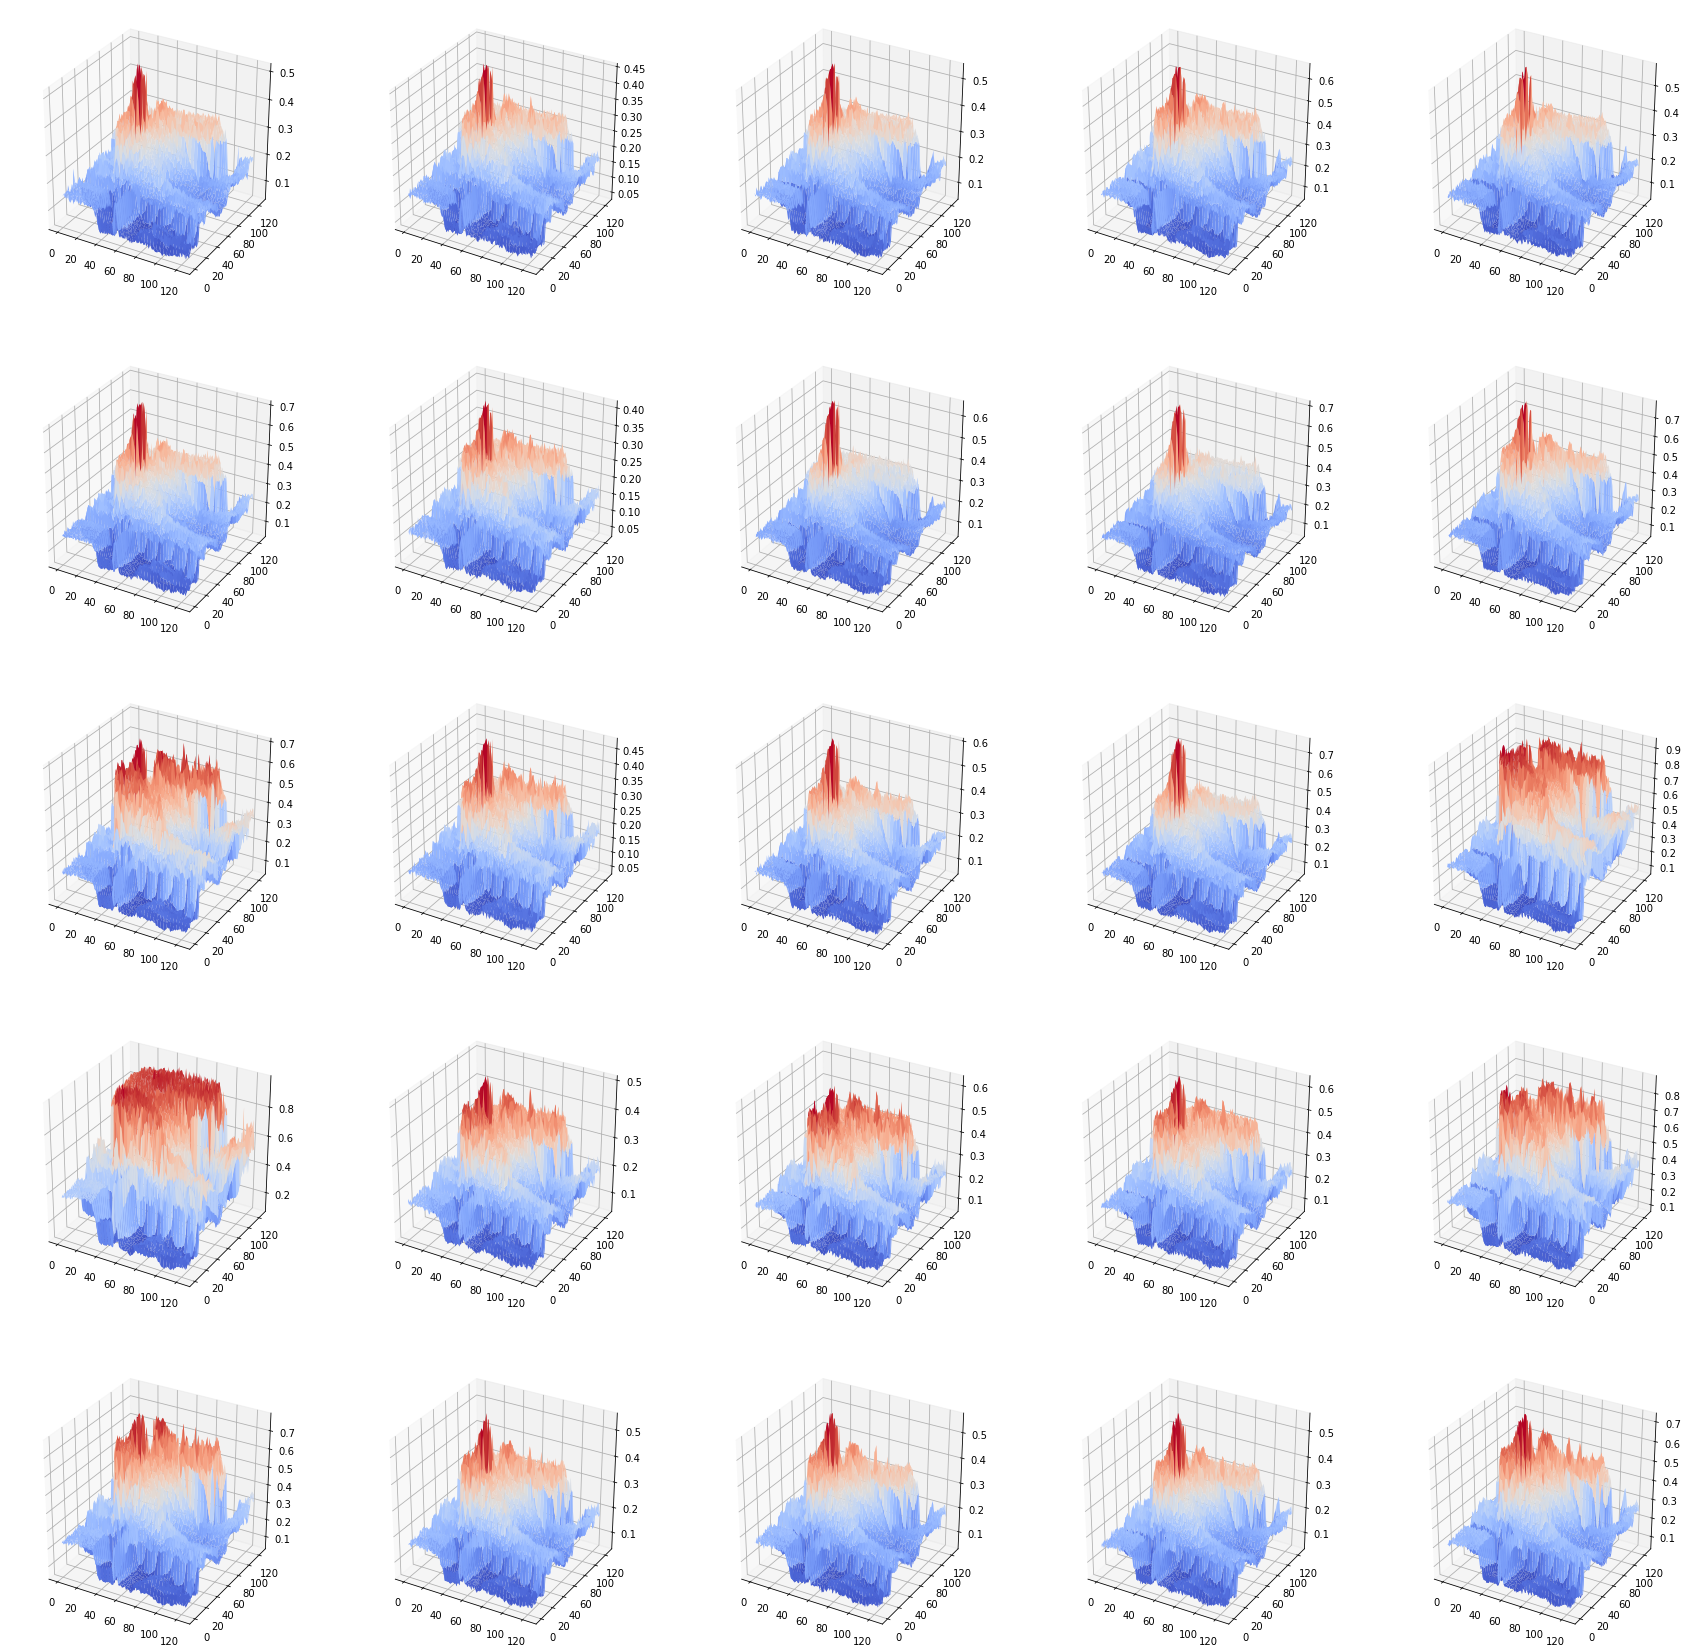

In [44]:
X = np.arange(0, img_chsi_part.shape[0])
Y = np.arange(0, img_chsi_part.shape[1])
Y, X = np.meshgrid(Y,X)


fig = plt.figure(figsize=(30,30))
for i in range(5):
    for j in range(5):
        ax = fig.add_subplot(5, 5, i*5+j+1, projection='3d')
        ax.plot_surface(X,Y,img_chsi_part[:,:,i*5+j], cmap=cm.coolwarm)



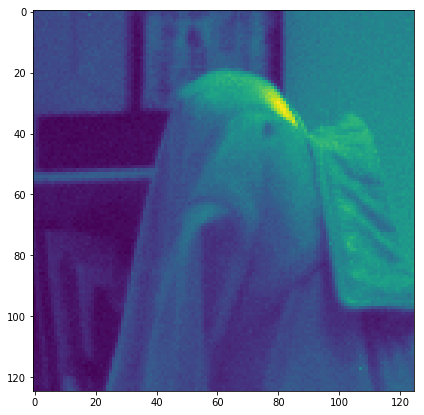

In [933]:
plt.figure(figsize=(7,7))
plt.imshow(img_chsi_part[:,:,0])

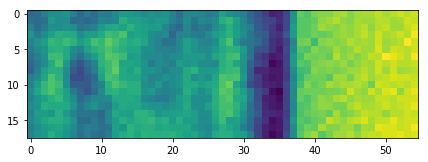

In [934]:
plt.figure(figsize=(7,7))
plt.imshow(img_chsi_part[:18,45:100,0])

In [69]:
img_chsi_part[50:,95:105,0].flatten().shape[0]

750

In [524]:
X_train_true = np.zeros((img_chsi_part[31:,55:83,0].flatten().shape[0],25))
Y_train_true = np.ones((X_train_true.shape[0], 1))

X_test_true = np.zeros((img_chsi_part[50:,95:105,0].flatten().shape[0],25))
Y_test_true = np.ones((X_test_true.shape[0], 1))

In [525]:
X_train_false1 = np.zeros((img_chsi_part[:80,:33,0].flatten().shape[0],25))
X_train_false2 = np.zeros((img_chsi_part[:25,100:,0].flatten().shape[0],25))
X_train_false = np.vstack((X_train_false1, X_train_false2))
Y_train_false = np.zeros((X_train_false.shape[0],1))

X_test_false = np.zeros((img_chsi_part[:18,45:100,0].flatten().shape[0],25))
Y_test_false = np.zeros((X_test_false.shape[0], 1))

In [526]:
# TRAIN EXAMPLES

# True examples
# X_train_true = np.zeros((img_chsi_part[31:,55:83,0].flatten().shape[0],25))
for i in range(31,img_chsi_part.shape[0]):
    for j in range(55,83):
        X_train_true[(i-31)*len(range(55,83))+(j-55)] = img_chsi_part[i,j,:]

# False examples 1
# X_train_false1 = np.zeros((img_chsi_part[:80,:33,0].flatten().shape[0],25))
for i in range(0,80):
    for j in range(0,33):
        X_train_false[(i)*len(range(0,33))+(j)] = img_chsi_part[i,j,:]

# False examples 2
# X_train_false2 = np.zeros((img_chsi_part[:25,100:,0].flatten().shape[0],25))
for i in range(0,25):
    for j in range(100,img_chsi_part.shape[1]):
        X_train_false[(i)*len(range(100,img_chsi_part.shape[1]))+(j-100) + 2640] = img_chsi_part[i,j,:]

In [527]:
# TEST EXAMPLES

# True examples
# X_test_true = np.zeros((img_chsi_part[50:,95:105,0].flatten().shape[0],25))
for i in range(50,img_chsi_part.shape[0]):
    for j in range(95,105):
        X_test_true[(i-50)*len(range(95,105))+(j-95)] = img_chsi_part[i,j,:]
        
# False examples
# X_test_false = np.zeros((img_chsi_part[:20,45:100,0].flatten().shape[0],25))
for i in range(0,20):
    for j in range(95,105):
        X_test_true[(i)*len(range(95,105))+(j-95)] = img_chsi_part[i,j,:]



In [528]:
X_train = np.vstack((X_train_false, X_train_true))
Y_train = np.vstack((Y_train_false, Y_train_true))

X_test = np.vstack((X_test_false, X_test_true))
Y_test = np.vstack((Y_test_false, Y_test_true))

In [531]:
def X_train_more(X_train, Y_train):
    addit_X_train_feature = np.zeros((1000,1))
    addit_Y_train_false = np.zeros((1000,1))
    addit_X_train_false = np.zeros((1000,25))
    for i in range(X_train.shape[1]):
        
        maxval = np.max(X_train[:,i])
        minval = np.min(X_train[:,i])
        if maxval + maxval*0.3 < 1:
            addit_X_train_feature = np.random.uniform(maxval*0.1, maxval + maxval*0.3,(500,1))
        elif maxval + maxval*0.2 < 1:
            addit_X_train_feature = np.random.uniform(maxval*0.1, maxval + maxval*0.2,(500,1))
        else:
            addit_X_train_feature = np.random.uniform(maxval, maxval,(500,1))
        addit_X_train_false[:500,i:i+1] = addit_X_train_feature
        
        maxval = np.max(X_train[:,i])
        minval = np.min(X_train[:,i])
        if minval - minval*0.3 > 0:
            addit_X_train_feature = np.random.uniform(minval*0.1, minval - minval*0.3,(500,1))
        elif maxval - maxval*0.2 > 0:
            addit_X_train_feature = np.random.uniform(minval*0.1, maxval - minval*0.2,(500,1))
        else:
            addit_X_train_feature = np.random.uniform(minval, minval,(500,1))
        addit_X_train_false[500:1000,i:i+1] = addit_X_train_feature
        
    X_train = np.vstack((X_train, addit_X_train_false))
    Y_train = np.vstack((Y_train, addit_Y_train_false))
    return X_train, Y_train

In [532]:
X_train, Y_train = X_train_more(X_train, Y_train)

In [533]:
X_train.shape

(6897, 25)

In [413]:
def print_sets(img_sets):
    img_sets[31:,55:83] = 1
    img_sets[:80,:33] = 1
    img_sets[:25,100:] = 1
    
    img_sets[50:,95:105] = 0
    img_sets[:18,45:100] = 0
    return img_sets

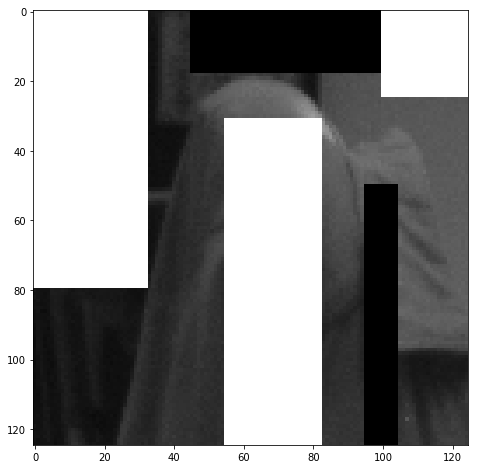

In [935]:
img_sets = img_chsi_part.copy()
img_sets = print_sets(img_sets[:,:,0])
plt.figure(figsize=(8,8))
plt.imshow(img_sets, cmap = cm.Greys_r)

In [342]:
seed = 105
clf = SVC(random_state=seed, max_iter=-1)

In [585]:
def fitSVM(X_train, Y_train, X_test, Y_test):
    f1_arr = []
    c_arr = []
    f1 = 0
    C_examples = np.logspace(0.7, 1.5, 50)
    for c in C_examples:
        clf = SVC(random_state=seed, max_iter=-1, C=c, kernel="rbf")
        clf.fit(X_train, Y_train)
        newf1 = f1_score(Y_test, clf.predict(X_test), average='micro')
        f1_arr.append(newf1)
        c_arr.append(c)
        if newf1 > f1:
            f1 = newf1
            c = i
    return f1, c, f1_arr, c_arr
    

In [ ]:
def fitSVMpoly(X_train, Y_train, X_test, Y_test):
    f1_arr = []
    c_arr = []
    f1 = 0
    C_examples = np.logspace(5, 10, 50)
    for c in C_examples:
        clf = SVC(random_state=seed, max_iter=-1, C=c, kernel="poly", degree = 5)
        clf.fit(X_train, Y_train)
        newf1 = f1_score(Y_test, clf.predict(X_test), average='micro')
        f1_arr.append(newf1)
        c_arr.append(c)
        if newf1 > f1:
            f1 = newf1
            c = i
    return f1, c, f1_arr, c_arr

In [576]:
f1, c, f1_arr, c_arr = fitSVM(X_train, Y_train, X_test, Y_test)

C:\Users\Alexey\Miniconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


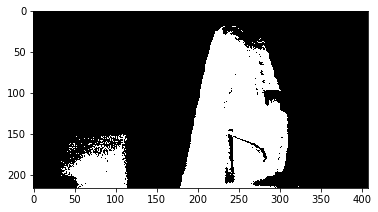

In [845]:
# Epoch 30 20-10-5 batchsize = 64
img = paint_jacket_NN(model, img_chsi)
plt.imshow(img, cmap = cm.Greys_r)

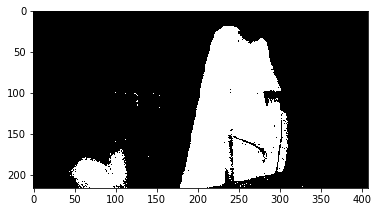

In [879]:
# Epoch 30 30-25-20 batchsize = 64
img = paint_jacket_NN(model, img_chsi)
plt.imshow(img, cmap = cm.Greys_r)

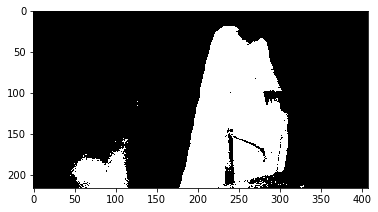

In [885]:
# Epoch 30 30-25-25 batchsize = 256
img = paint_jacket_NN(model, img_chsi)
plt.imshow(img, cmap = cm.Greys_r)

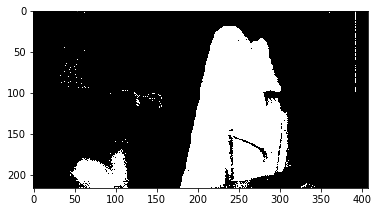

In [905]:
# Epoch 30 30-25-25 batchsize = 256
img = paint_jacket_NN(model, img_chsi)
plt.imshow(img, cmap = cm.Greys_r)

In [904]:
model = Sequential()
model.add(Dense(50, input_dim=25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(35, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          epochs=40,
          batch_size=256)
score = model.evaluate(X_test, Y_test, batch_size=256) 

Epoch 1/40
6897/6897 [==============================] - 2s - loss: 0.6777 - acc: 0.6110     
Epoch 2/40
6897/6897 [==============================] - 0s - loss: 0.6429 - acc: 0.6287     
Epoch 3/40
6897/6897 [==============================] - 0s - loss: 0.5941 - acc: 0.6459     
Epoch 4/40
6897/6897 [==============================] - 0s - loss: 0.5185 - acc: 0.7161     - ETA: 0s - loss: 0.5294 - acc: 0.702
Epoch 5/40
6897/6897 [==============================] - 0s - loss: 0.4129 - acc: 0.8328     
Epoch 6/40
6897/6897 [==============================] - 0s - loss: 0.2961 - acc: 0.9247     
Epoch 7/40
6897/6897 [==============================] - 0s - loss: 0.2137 - acc: 0.9546     
Epoch 8/40
6897/6897 [==============================] - 0s - loss: 0.1596 - acc: 0.9678     
Epoch 9/40
6897/6897 [==============================] - 0s - loss: 0.1410 - acc: 0.9726     
Epoch 10/40
6897/6897 [==============================] - 0s - loss: 0.1218 - acc: 0.9771     
Epoch 11/40
6897/6897 [=========

In [814]:
def paint_jacket(img, algorithm, c=1, kernel="rbf", degree=3, gamma="auto", model=None, clf=None):
    if algorithm == "SVM":
        clf = SVC(random_state=seed, max_iter=-1, C=c, kernel=kernel, degree=degree, gamma=gamma)
        clf.fit(X_train, Y_train)
    
    bin_image = np.zeros((img[:,:,0].flatten().shape[0], img.shape[2]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            bin_image[i*len(range(img.shape[1]))+j] = img[i,j,:].flatten()   
    if algorithm == "SVM":
        bin_image = clf.predict(bin_image)
    elif algorithm == "NN":
        bin_image = model.predict(bin_image)
    else:
        raise ("DAMN")
    bin_image = np.round(bin_image)
    bin_image = bin_image[:].reshape(img.shape[0], img.shape[1])
    return bin_image

C:\Users\Alexey\Miniconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


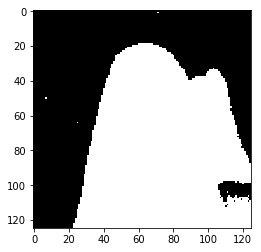

In [817]:
# RBF, C=1000, gamma=default
img = paint_jacket(img_chsi_part, "SVM", clf=clf, c=1000)
plt.imshow(img, cmap = cm.Greys_r)

C:\Users\Alexey\Miniconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


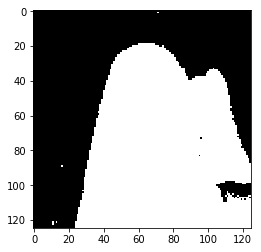

In [818]:
# Poly C = 10000000000.0, degree = 5
img = paint_jacket(img_chsi_part, "SVM", clf=clf, c=10000000000, degree=5)
plt.imshow(img, cmap = cm.Greys_r)

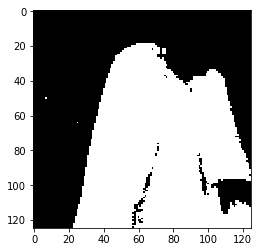

In [826]:
# Epoch 20 15-15 batchsize = 128
img = paint_jacket(img_chsi_part, "NN", model=model)
plt.imshow(img, cmap = cm.Greys_r)

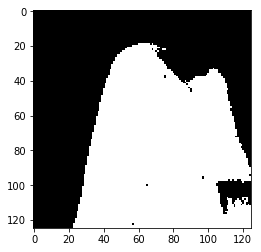

In [865]:
# Epoch 20 15-15 batchsize = 128
img = paint_jacket(img_chsi_part, "NN", model=model)
plt.imshow(img, cmap = cm.Greys_r)

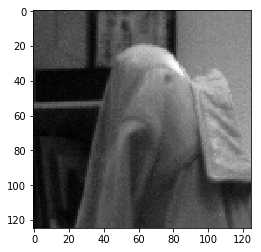

In [631]:
plt.imshow(img_chsi_part[:,:,0], cmap = cm.Greys_r)

C:\Users\Alexey\Miniconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


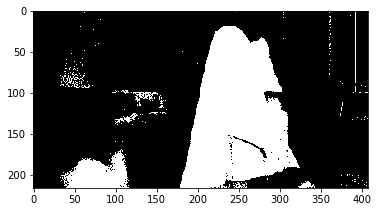

In [820]:
# RBF, C=1000, gamma=auto
img = paint_jacket(img_chsi, "SVM", clf=clf, c=1000)
plt.imshow(img, cmap = cm.Greys_r)

C:\Users\Alexey\Miniconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


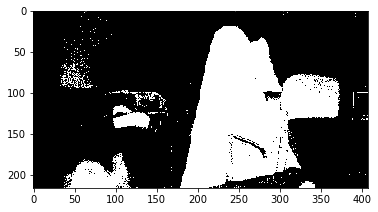

In [821]:
# Poly C = 10000000000.0, degree = 5
img = paint_jacket(img_chsi, "SVM", clf=clf, c=10000000000, degree=5)
plt.imshow(img, cmap = cm.Greys_r)

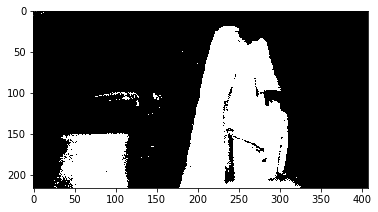

In [827]:
# Epoch 20 15-15 batchsize = 128
img = paint_jacket(img_chsi, "NN", model=model)
plt.imshow(img, cmap = cm.Greys_r)

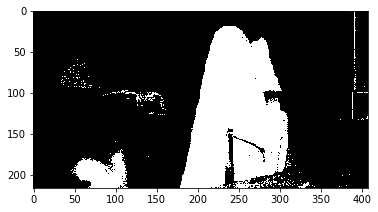

In [829]:
# Epoch 100 15-15 batchsize = 128
img = paint_jacket(img_chsi, "NN", model=model)
plt.imshow(img, cmap = cm.Greys_r)

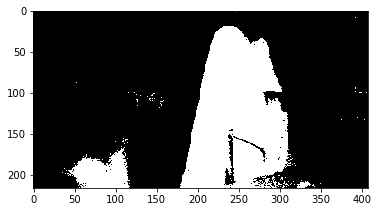

In [831]:
#Epoch 60  20-20 batchsize = 128
img = paint_jacket_NN(model, img_chsi)
plt.imshow(img, cmap = cm.Greys_r)

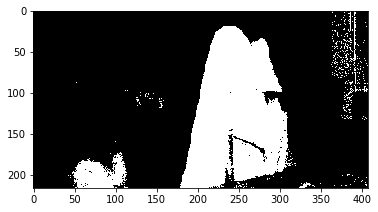

In [833]:
#Epoch 60  25-5 batchsize = 128
img = paint_jacket_NN(model, img_chsi)
plt.imshow(img, cmap = cm.Greys_r)

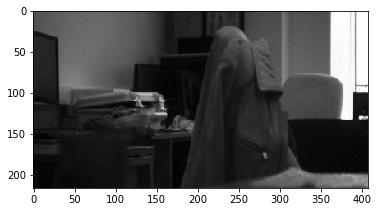

In [557]:
plt.imshow(img_chsi[:,:,0], cmap = cm.Greys_r)